In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

In [2]:
BS=32
WK=5
SELECTED_VIEW = 'pa_la'

In [3]:
diseases = [
            "Atelectasis",
"Cardiomegaly",
"Consolidation",                 
"Edema",                         
"Enlarged Cardiomediastinum", 
"Fracture",                      
"Lung Lesion",            
"Lung Opacity",              
"No Finding",               
"Pleural Effusion",      
"Pleural Other",    
"Pneumonia",         
"Pneumothorax",               
"Support Devices"     
]

## Model loading

### Crop Function

In [4]:
def find_last_layer(model):
      for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
          return layer.name
      raise ValueError("Could not find the last convolution layer.")

In [5]:
@tf.function
def get_focus_area(imgs, last_conv_output, threshold = 0.7):
  last_conv_output = tf.math.abs(last_conv_output)
  last_conv_output_max = tf.math.reduce_max(last_conv_output, axis=-1)
  last_conv_output_max_min = tf.math.reduce_min(last_conv_output_max, axis=0)
  last_conv_output_max_max = tf.math.reduce_max(last_conv_output_max, axis=0)
  last_conv_output_norm = (last_conv_output_max - last_conv_output_max_min) / (last_conv_output_max_max-last_conv_output_max_min)
  last_conv_output_cast = tf.cast(last_conv_output_norm >= threshold, tf.float32)
  return last_conv_output_cast

In [6]:
@tf.function
def generate_box(masked):
  positions = tf.where(masked == 1)
  positions = tf.cast(positions, dtype=tf.float32)
  if positions.shape[0] == 0:
    box = tf.constant([0.,0., 1., 1.], dtype=tf.float32)
  else:
    xmin = tf.math.reduce_min(positions[:,0])/6.
    xmax = tf.math.reduce_max(positions[:,0])/6.
    ymin = tf.math.reduce_min(positions[:,1])/6.
    ymax = tf.math.reduce_max(positions[:,1])/6.
    if xmin == xmax:
      xmax = tf.math.minimum(xmin + 0.3, 1.)
    if ymin == ymax:
      ymax = tf.math.minimum(ymin + 0.3, 1.)
    ymin = tf.cond(tf.math.is_inf(ymin), lambda: 0., lambda: ymin)
    xmin = tf.cond(tf.math.is_inf(xmin), lambda: 0., lambda: xmin)
    ymax = tf.cond(tf.math.is_inf(ymax), lambda: 1., lambda: ymax)
    xmax = tf.cond(tf.math.is_inf(xmax), lambda: 1., lambda: xmax)
    box = tf.stack([ymin,xmin, ymax, xmax])
  return box

In [7]:
@tf.function
def generate_box_batch(data):
  imgs, last_conv_output = data
  masks = get_focus_area(imgs, last_conv_output)

  batch_size = tf.shape(imgs)[0]
  boxes = tf.TensorArray(tf.float32, size=batch_size)
  for i in range(batch_size):
    boxes.write(i, generate_box(masks[i]))
  boxes = boxes.stack()
  return crop_imgs(imgs, boxes, batch_size)

In [8]:
@tf.function
def crop_imgs(imgs, boxes, bs=BS, labels=None):
  idxs = tf.range(bs)
  cropped_images = tf.image.crop_and_resize(imgs, boxes, idxs, (224,224), method='nearest')
  if labels is None:
    return cropped_images
  return cropped_images, labels

### Model Loading

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121

In [10]:
global_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
local_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [11]:
def createMergeModel(global_model, local_model, suffix):
  global_last_conv_layer = find_last_layer(global_model)
  global_last_conv_layer_output=global_model.get_layer(global_last_conv_layer).output
  
  focus_layer = Lambda(generate_box_batch)([global_model.layers[0].output,global_last_conv_layer_output])

  local_last_conv_layer = find_last_layer(local_model)
  local_last_conv_layer_output=local_model.get_layer(local_last_conv_layer).output

  tmp_local_model = Model(inputs=local_model.input, outputs=local_last_conv_layer_output)

  local_branch = tmp_local_model(focus_layer)
  local_branch = GlobalAveragePooling2D()(local_branch)

  global_branch = GlobalAveragePooling2D()(global_last_conv_layer_output)

  merge_branch = Concatenate(axis=-1, name='concatenate_1')([global_branch, local_branch])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=global_model.input, outputs=merge_branch)

  for layer in model.layers:
    layer._name = layer.name + suffix
  return model

In [12]:
side_model = createMergeModel(global_model, local_model, "_side")
front_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
front_model = createMergeModel(global_model, local_model, "_front")
side_model = DenseNet121(include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
def createMultiModel(front_model, side_model):
  front_output = front_model.get_layer('concatenate_1_front').output

  side_output=side_model.output
  side_output = GlobalAveragePooling2D()(side_output)

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [13]:
def createMultiModel(front_model, side_model):
  side_output = side_model.get_layer('concatenate_1_side').output

  front_output = front_model.output
  front_output = GlobalAveragePooling2D()(front_output)
  # side_output = side_model.get_layer('concatenate_1_side').output

  merge_branch = Concatenate(axis=-1)([front_output, side_output])
  merge_branch = Dense(14, activation="sigmoid")(merge_branch)

  model = Model(inputs=[front_model.input, side_model.input], outputs=merge_branch)
  return model

In [14]:
model = createMultiModel(front_model, side_model)

In [15]:
model.load_weights('/content/drive/My Drive/AGCNNMulti/DenseNetComPALA2/model1-003-0.118767-0.139658.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shared drives/CMB - corpora/Chest_x-ray_report_Jan2020/Guide_MIMIC_OGR_Baseline_BS32/DenseNetPALABaseline/model1-002-0.139640-0.141854.h5')

In [26]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_side (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_side (ZeroPaddin (None, 230, 230, 3)  0           input_1_side[0][0]               
__________________________________________________________________________________________________
conv1/conv_side (Conv2D)        (None, 112, 112, 64) 9408        zero_padding2d_side[0][0]        
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
_______________________________________________________________________________________

## Data Pipeline

### TFrecord

In [16]:
def augment_img_wot(image):
  image = tf.image.resize(image, [264,264])
  image = tf.image.crop_to_bounding_box(image, 20,20, 224,224)
  return image

In [17]:
def read_tfrecord(example, output_mode='both'):
    features = {
        "image_front": tf.io.FixedLenFeature([], tf.string),
        "image_side": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.VarLenFeature(tf.float32),  
        "view": tf.io.FixedLenFeature([], tf.string),
        "select": tf.io.FixedLenFeature([], tf.int64),
        "study_id": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    label  = tf.reshape(tf.sparse.to_dense(example['label']), [1, 14])
    label = tf.where(tf.math.is_nan(label), tf.ones_like(label) * 0, label)
    label = tf.where(label == -1, tf.ones_like(label) * 0, label)
    label = label[0]

    select = example['select']
    if output_mode=='label':
      return label, select
    elif output_mode=='view_label':
      return label, example['study_id'],example['view'], select
    elif output_mode=='combine_label':
      return (label,label, label), select
    image_front = tf.image.decode_jpeg(example['image_front'], channels=3)
    image_side =  tf.image.decode_jpeg(example['image_side'], channels=3)

    image_front = augment_img_wot(image_front)
    image_side = augment_img_wot(image_side)
    if output_mode=='both':
      return [image_front, image_side], label, select
    elif output_mode=='img_view':
      return [image_front, image_side], example['view'], select
    elif output_mode=='both_view':
      return [image_front, image_side], example['study_id'], example['view'], select
    else:
      return [image_front, image_side], select

### Image Selection and Preprocessing



In [18]:
def select_image(*record):
  select = record[-1]
  return select == 1

def remove_select(*record):
  return record[:-1]

def select_view_cat(view, *record):
  current_view = record[-1]
  return current_view == view

def remove_view(*record):
  return record[:-1]

def select_view(view, *record):
  record = record[0]
  img = None
  if view == 'frontal':
    img = record[0][0]
  elif view == 'side':
    img = record[0][1]
  else: 
    img = record[0]
  if len(record) == 1:
    return img
  return img, record[1]

def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image_net_mean = np.array([0.485, 0.456, 0.406])
  image_net_std = np.array([0.229, 0.224, 0.225])
  image = tf.math.subtract(image, image_net_mean)
  image = tf.math.divide(image, image_net_std)
  return image
def preprocess_image_dataset(image, label=None, replicate_label=False):
  image = preprocess_image(image)
  if len(image.shape) ==5:
    image = (image[:,0], image[:,1])
  if label is None:
    return image
  if replicate_label:
    label = (label, label, label)
  return image, label

def choose_view(ds, view):
  ds = ds.filter(lambda *record: select_view_cat(view, *record)).map(remove_view, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

def choose_selected(ds):
  ds = ds.filter(select_image).map(remove_select, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  return ds

### Data Loader

In [19]:
filenames = tf.io.gfile.glob('/content/drive/My Drive/AG-CNN/tfrecord_test_mul_nr/*.tfrec')
test_dsr = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = test_dsr.map(lambda record : read_tfrecord(record, 'both_view'), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = test_dsr.map(lambda record : read_tfrecord(record, 'view_label'), num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dsrs_img_view = choose_selected(test_dsrs_img_view)
test_dsrs_lab_view = choose_selected(test_dsrs_lab_view)

# test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).map(lambda *record : select_view('side',record)).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_img_view = choose_view(test_dsrs_img_view, SELECTED_VIEW).batch(BS).map(preprocess_image_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(tf.data.experimental.AUTOTUNE)
test_dsrs_lab_view = choose_view(test_dsrs_lab_view, SELECTED_VIEW).prefetch(tf.data.experimental.AUTOTUNE)

## GradCam

In [20]:
counts = np.zeros((6, 14))

In [21]:
result_merge = pd.read_csv('/content/drive/My Drive/AG-CNNPALA2_merge.csv')

In [22]:
result_merge.fillna(0, inplace=True)

In [23]:
for i in range(14):
  total_positive = len(result_merge[ (result_merge[diseases[i]+ '_y'] == 1)])
  positive = len(result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == 1)])
  total_uncertain = len(result_merge[ (result_merge[diseases[i]+ '_y'] == -1)])
  uncertain = len(result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == -1)])
  total_negative = len(result_merge[ ((result_merge[diseases[i]+ '_y'] == 0)|  (result_merge[diseases[i]+ '_y'].isnull()))])
  negative = len(result_merge[(result_merge[diseases[i]+'_x'] == 1) & ((result_merge[diseases[i]+ '_y'] == 0)|  (result_merge[diseases[i]+ '_y'].isnull()))])
  counts[0][i] = positive
  counts[1][i] = total_positive
  counts[2][i] = uncertain
  counts[3][i] = total_uncertain
  counts[4][i] = negative
  counts[5][i] = total_negative

In [24]:
np.savetxt("/content/drive/My Drive/test.csv", counts, delimiter=",")

In [ ]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image,[224,224])
  image = image / 255.
  image_net_mean = np.array([0.485, 0.456, 0.406])
  image_net_std = np.array([0.229, 0.224, 0.225])
  image = tf.math.subtract(image, image_net_mean)
  image = tf.math.divide(image, image_net_std)
  return tf.expand_dims(image, 0)

### One view

In [ ]:
class GradCamSingle:
    def __init__(self, model, layer_name=None):
      self.model=model
      self.layer_name = layer_name

      if self.layer_name is None:
        self.layer_name = self.find_last_layer()
   
    def find_last_layer(self):
      for layer in reversed(self.model.layers):
        if len(layer.output_shape) == 4:
          return layer.name
      raise ValueError("Could not find the last convolution layer.")

    def compute_head_map(self, image, classIdx, eps=1e-8):
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layer_name).output,
				self.model.output])
      
      with tf.GradientTape() as tape:
        input_image = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(input_image)
        loss = predictions[:, classIdx]
      
      # size:(batch, height, width, convolutions)
      grads = tape.gradient(loss, convOutputs)

      castConvOutputs = tf.cast(convOutputs > 0, tf.float32)
      castGrads = tf.cast(grads > 0, tf.float32)

      guidedGrads = castConvOutputs * castGrads * grads

      # extract batch dimension
      convOutputs = convOutputs[0]
      guidedGrads = guidedGrads[0]

      weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
      cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

      (w, h) = (image.shape[2], image.shape[1])
      heatmap = cv2.resize(cam.numpy(), (w, h))

      # scaling
      num = heatmap - np.min(heatmap)
      deno = (heatmap.max() - heatmap.min()) + eps
      heatmap = num / deno
      heatmap = (heatmap * 255).astype("uint8")
    
      return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
      heatmap = cv2.applyColorMap(heatmap, colormap)
      output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
      return (heatmap, output)

In [ ]:
cam = GradCamSingle(model)

In [ ]:
def plot_grad(model, cam, idx, plt_idx, paths):
  for count,path in enumerate(paths):
    img = cv2.imread(path)
    img_resize = tf.image.resize(img, [224,224], method='nearest')
    img_resize = img_resize.numpy()
    # img_resize = cv2.resize(img, (224,224))
    img = preprocess_image(img)
    pred = model.predict(img, verbose=1)
    heatmap = cam.compute_head_map(img, idx)
    result = cam.overlay_heatmap(heatmap,img_resize)
    plt.subplot(3, 4, plt_idx+count)
    plt.axis('off')
    plt.imshow(result[1])
    title = str(pred[0][idx]) + '\n' + path[59:67]
    plt.gca().set_title(title)

1/1 [==============================] - 0s 2ms/step


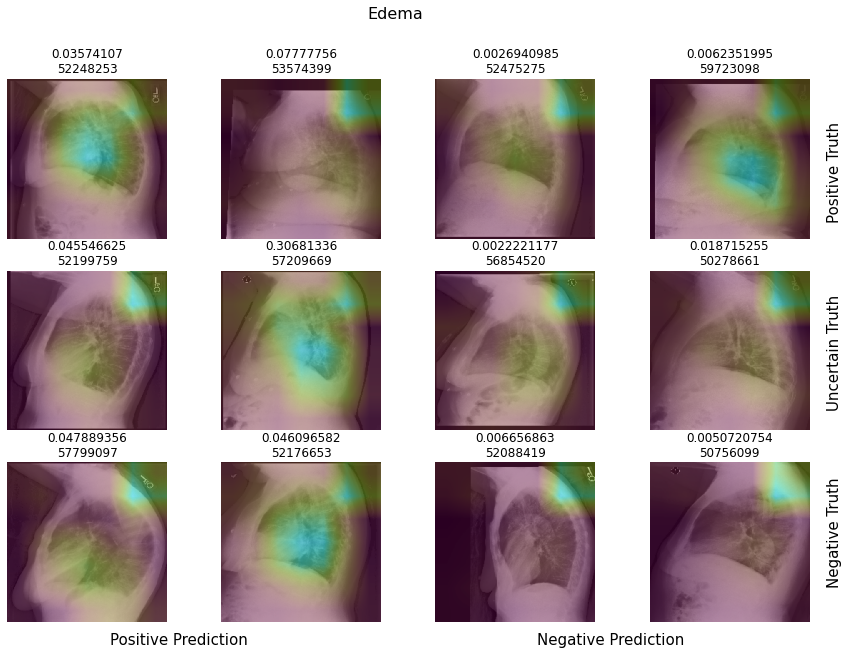

In [ ]:
for i in range(3,4):
  fig = plt.figure(figsize=(15,10))
  fig.suptitle(diseases[i], fontsize=16)
  fig.subplots_adjust(wspace=0.1)
  plt.figtext(0.3,0.1,"Positive Prediction", va="center", ha="center", size=15)
  plt.figtext(0.7,0.1,"Negative Prediction", va="center", ha="center", size=15)
  plt.figtext(0.9, 0.75, "Positive Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.5, "Uncertain Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.25, "Negative Truth", rotation=90, va='center', size=15)
  p_positive = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == 1)]['side'].iloc[np.random.randint(counts[0][i], size=2)]
  plot_grad(model, cam, i, 1,p_positive)
  n_positive = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == 1)]['side'].iloc[np.random.randint(counts[1][i] - counts[0][i], size=2)]
  plot_grad(model, cam, i, 3,n_positive)
  p_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == -1)]['side'].iloc[np.random.randint(counts[2][i], size=2)]
  plot_grad(model, cam, i, 5,p_uncertain)
  n_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == -1)]['side'].iloc[np.random.randint(counts[3][i] - counts[2][i], size=2)]
  plot_grad(model, cam, i, 7,n_uncertain)
  p_negative = result_merge[(result_merge[diseases[i]+'_x'] == 1) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]['side'].iloc[np.random.randint(counts[4][i], size=2)]
  plot_grad(model, cam, i, 9,p_negative)
  n_negative = result_merge[(result_merge[diseases[i]+'_x'] == 0) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]['side'].iloc[np.random.randint(counts[5][i] - counts[4][i], size=2)]
  plot_grad(model, cam, i, 11,n_negative)
  plt.show()

In [ ]:
test_img = preprocess_image(test)

In [ ]:
model.predict(test_img)

array([[3.34104057e-03, 3.42141688e-01, 4.03627550e-04, 3.17307599e-02,
        3.30537558e-03, 4.60307486e-03, 1.19483571e-04, 2.00059917e-03,
        8.76251698e-01, 1.13600574e-04, 7.08975480e-04, 3.26188817e-03,
        3.06912727e-04, 2.51527727e-02]], dtype=float32)

In [ ]:
test_resize = cv2.resize(test, (224,224))

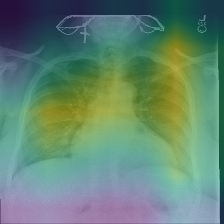

In [ ]:
heatmap = cam.compute_head_map(test_img, 3)
result = cam.overlay_heatmap(heatmap,test_resize)
cv2_imshow(result[1])

In [ ]:
meta = pd.read_csv("/content/drive/My Drive/mimic_reports/mimic-cxr-2.0.0-chexpert.csv")

In [ ]:
meta[meta['study_id'] == 52418569]

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
1822,10080695,52418569,1.0,-1.0,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,0.0,NaN,1.0


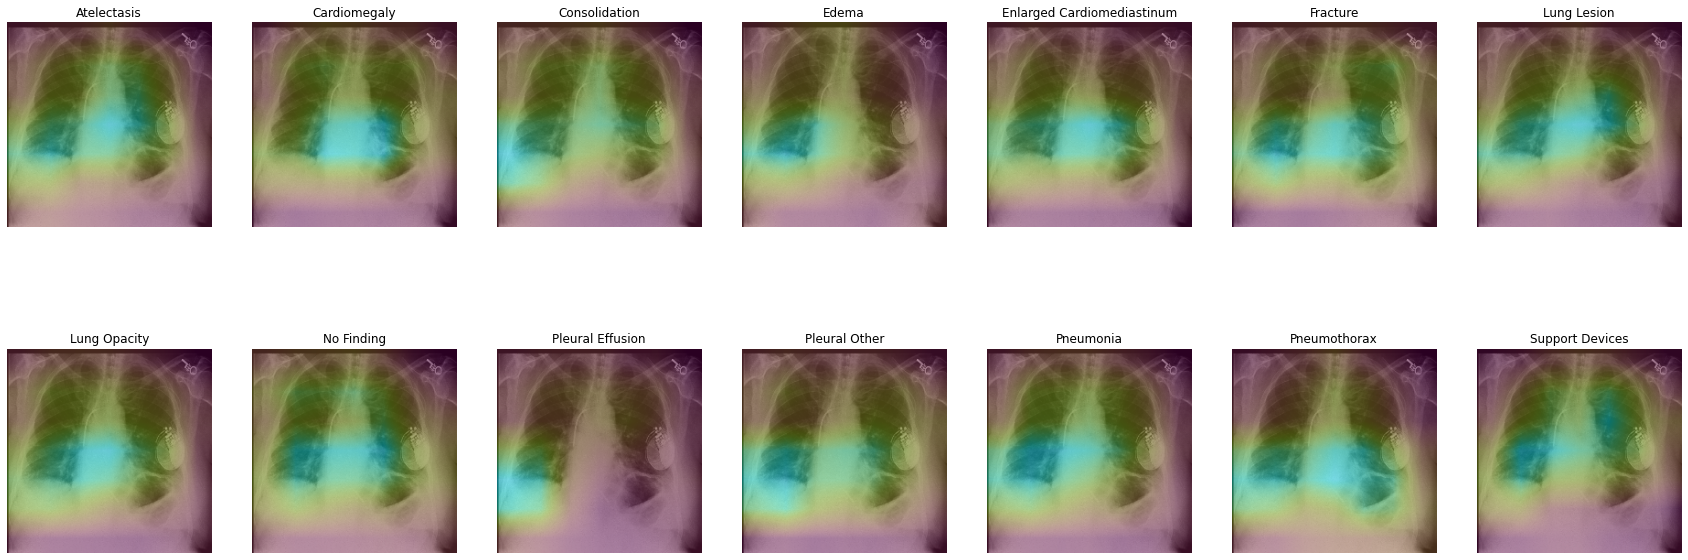

In [ ]:
fig, ax = plt.subplots(2, 7, figsize=(30,10))
fig.subplots_adjust(hspace=.5)
idx = 0
for row in ax:
  for col in row:
    col.axis('off')
    col.set_title(diseases[idx])
    heatmap = cam.compute_head_map(test_img, idx)
    result = cam.overlay_heatmap(heatmap,test_resize)
    col.imshow(result[1])
    idx+=1

### One view ratio

In [ ]:
class GradCamSingleUpperRightCount:
    def __init__(self, model, layer_name=None):
      self.model=model
      self.layer_name = layer_name

      if self.layer_name is None:
        self.layer_name = self.find_last_layer()
   
    def find_last_layer(self):
      for layer in reversed(self.model.layers):
        if len(layer.output_shape) == 4:
          return layer.name
      raise ValueError("Could not find the last convolution layer.")

    def compute_heat_map(self, image, classIdx, eps=1e-8):
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layer_name).output,
				self.model.output])
      
      with tf.GradientTape() as tape:
        (convOutputs, predictions) = gradModel(image)
        loss = predictions[:, classIdx]
      
      # size:(batch, height, width, convolutions)
      grads = tape.gradient(loss, convOutputs)

      castConvOutputs = tf.cast(convOutputs > 0, tf.float32)
      castGrads = tf.cast(grads > 0, tf.float32)

      guidedGrads = castConvOutputs * castGrads * grads

      weights = tf.reduce_mean(guidedGrads, axis=(1, 2))
      weights = tf.expand_dims(weights, axis=1)
      weights = tf.expand_dims(weights, axis=1)
      
      cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
      heatmap = cam.numpy()

      # scaling
      num = heatmap - np.min(heatmap, axis=(1,2))[:,np.newaxis,np.newaxis]
      deno = (np.max(heatmap, axis=(1,2)) - np.min(heatmap, axis=(1,2))) + eps
      heatmap = num / deno[:,np.newaxis,np.newaxis]
      heatmap = (heatmap * 255).astype("uint8")

      return heatmap

      # return heatmap[0,5] > 200. or heatmap[0,6] > 200. or heatmap[1,5] > 200. or heatmap[1,6] > 200.
    def count_upper_right(self, heatmap, sid, df, count_dict, idx):
      for id, map in enumerate(heatmap):
        current = df[df['study_id'] == sid[id]]
        if len(current) == 0:
          continue
        count_check = False
        if map[0,5] > 200. or map[0,6] > 200. or map[1,5] > 200. or map[1,6] > 200.:
          count_check = True
        max_other = max(np.max(map[2:]),np.max(map[0:1,0:5]))
        pred = current[diseases[idx] + "_x"].iloc[0]
        truth = current[diseases[idx] + "_y"].iloc[0]
        if count_check and max_other < 200:
          if pred:
            if truth == -1:
              count_dict[4][idx]+=1
            elif truth == 0:
              count_dict[8][idx]+=1
            else:
              count_dict[0][idx]+=1
          else:
            if truth == -1:
              count_dict[6][idx]+=1
            elif truth == 0:
              count_dict[10][idx]+=1
            else:
              count_dict[2][idx]+=1
        if pred:
            if truth == -1:
              count_dict[5][idx]+=1
            elif truth == 0:
              count_dict[9][idx]+=1
            else:
              count_dict[1][idx]+=1
        else:
            if truth == -1:
              count_dict[7][idx]+=1
            elif truth == 0:
              count_dict[11][idx]+=1
            else:
              count_dict[3][idx]+=1
            

In [ ]:
cam = GradCamSingleUpperRightCount(model)

In [ ]:
count_dict = np.zeros((12, 14))

In [ ]:
for img, sid in tqdm.tqdm(test_dsrs_img_view):
  img = img.numpy()
  sid = sid.numpy()
  for idx in range(14):
    heatmap = cam.compute_heat_map(img, idx)
    cam.count_upper_right(heatmap, sid, result_merge, count_dict, idx)





0it [00:00, ?it/s]



1it [00:08,  8.25s/it]



2it [00:15,  7.90s/it]



3it [00:22,  7.66s/it]



4it [00:29,  7.46s/it]



5it [00:36,  7.34s/it]



6it [00:43,  7.25s/it]



7it [00:50,  7.21s/it]



8it [00:57,  7.19s/it]



9it [01:05,  7.25s/it]



10it [01:12,  7.19s/it]



11it [01:19,  7.14s/it]



12it [01:26,  7.10s/it]



13it [01:33,  7.08s/it]



14it [01:40,  7.09s/it]



15it [01:47,  7.08s/it]



16it [01:54,  7.07s/it]



17it [02:01,  7.19s/it]



18it [02:09,  7.17s/it]



19it [02:16,  7.17s/it]



20it [02:23,  7.14s/it]



21it [02:30,  7.12s/it]



22it [02:37,  7.12s/it]



23it [02:44,  7.09s/it]



24it [02:51,  7.07s/it]



25it [02:58,  7.16s/it]



26it [03:05,  7.12s/it]



27it [03:12,  7.08s/it]



28it [03:20,  7.10s/it]



29it [03:27,  7.08s/it]



30it [03:34,  7.05s/it]



31it [03:41,  7.05s/it]



32it [03:48,  7.04s/it]



33it [03:55,  7.16s/it]



34it [04:02,  7.13s/it]



35it [04:09,  7.12s/it]



36it [04:16,  7.09s/it]



37it [04:23

In [ ]:
np.savetxt("/content/drive/My Drive/test.csv", count_dict, delimiter=",")

### Two view

In [ ]:
class GradCam:
    def __init__(self, model, layer_names=None):
      self.model=model
      self.layer_names = layer_names

    def compute_head_map(self, front_image, side_image, classIdx, eps=1e-8):
      outputs = [self.model.get_layer(layer_name).output for layer_name in self.layer_names]
      outputs.append(self.model.output)
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=outputs)
      
      with tf.GradientTape(persistent=True) as tape:
        input_image_front = tf.cast(front_image, tf.float32)
        input_image_side = tf.cast(side_image, tf.float32)
        (conv_outputs_front, conv_outputs_side, predictions) = gradModel([input_image_front, input_image_side])
        loss = predictions[:, classIdx]
      
      # size:(batch, height, width, convolutions)
      grads_front = tape.gradient(loss, conv_outputs_front)
      grads_side = tape.gradient(loss, conv_outputs_side)

      castConvOutputsFront = tf.cast(conv_outputs_front > 0, tf.float32)
      castGradsFront = tf.cast(grads_front > 0, tf.float32)

      castConvOutputsSide = tf.cast(conv_outputs_side > 0, tf.float32)
      castGradsSide = tf.cast(grads_side > 0, tf.float32)

      guidedGradsFront = castConvOutputsFront * castGradsFront * grads_front
      guidedGradsSide = castConvOutputsSide * castGradsSide * grads_side

      # extract batch dimension
      conv_outputs_front = conv_outputs_front[0]
      guidedGradsFront = guidedGradsFront[0]

      conv_outputs_side = conv_outputs_side[0]
      guidedGradsSide = guidedGradsSide[0]

      weights_front = tf.reduce_mean(guidedGradsFront, axis=(0, 1))
      cam_front = tf.reduce_sum(tf.multiply(weights_front, conv_outputs_front), axis=-1)
      weights_side = tf.reduce_mean(guidedGradsSide, axis=(0, 1))
      cam_side = tf.reduce_sum(tf.multiply(weights_side, conv_outputs_side), axis=-1)

      (w, h) = (input_image_front.shape[2], input_image_front.shape[1])
      heatmap_front = cv2.resize(cam_front.numpy(), (w, h))
      heatmap_side = cv2.resize(cam_side.numpy(), (w, h))

      # scaling
      num = heatmap_front - np.min(heatmap_front)
      deno = (heatmap_front.max() - heatmap_front.min()) + eps
      heatmap_front = num / deno
      heatmap_front = (heatmap_front * 255).astype("uint8")

      num = heatmap_side - np.min(heatmap_side)
      deno = (heatmap_side.max() - heatmap_side.min()) + eps
      heatmap_side = num / deno
      heatmap_side = (heatmap_side * 255).astype("uint8")
    
      return heatmap_front, heatmap_side

    def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
      heatmap = cv2.applyColorMap(heatmap, colormap)
      output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
      return (heatmap, output)

In [ ]:
cam_multi = GradCam(model, ['relu_front', 'relu'])

In [ ]:
cam_front = GradCamSingle(front_model)
cam_side = GradCamSingle(side_model)

In [ ]:
def plot_grad(model_front,model_side, model_multi,cam_front,cam_side, cam_multi, idx, plt_idx, paths, rand_size):
  img_front = None
  img_side = None
  while img_front is None or img_side is None:
    rand_path = paths.iloc[np.random.randint(rand_size, size=1)]
    front_path = rand_path['frontal'].iloc[0]
    side_path = rand_path['side'].iloc[0]
    id = front_path[59:67]
    try:
      img_front = cv2.imread(front_path) 
      img_side = cv2.imread(side_path)
    except:
      pass
  img_front_resize = tf.image.resize(img_front, [224,224], method='nearest')
  img_front_resize = img_front_resize.numpy()
  img_side_resize = tf.image.resize(img_side, [224,224], method='nearest')
  img_side_resize = img_side_resize.numpy()
  img_front = preprocess_image(img_front)
  img_side = preprocess_image(img_side)
  pred_multi = model_multi.predict([img_front, img_side], verbose=1)
  pred_front = model_front.predict(img_front, verbose=1)
  pred_side = model_side.predict(img_side, verbose=1)
  heatmap_front_multi, heatmap_side_multi = cam_multi.compute_head_map(img_front, img_side, idx)
  result_front_multi = cam_multi.overlay_heatmap(heatmap_front_multi,img_front_resize)
  result_side_multi = cam_multi.overlay_heatmap(heatmap_side_multi,img_side_resize)

  heatmap_front = cam_front.compute_head_map(img_front, img_front, idx)
  result_front = cam_front.overlay_heatmap(heatmap_front,img_front_resize)

  heatmap_side = cam_side.compute_head_map(img_side, img_side, idx)
  result_side = cam_side.overlay_heatmap(heatmap_side,img_side_resize)

  plt.subplot(3, 4, plt_idx)
  plt.axis('off')
  plt.imshow(result_front[1])
  title = str(pred[0][idx]) + '\n' + id
  plt.gca().set_title(title)

  plt.subplot(3, 4, plt_idx + 1)
  plt.axis('off')
  plt.imshow(result_side[1])
  title = str(pred[0][idx]) + '\n' + id
  plt.gca().set_title(title)

1/1 [==============================] - 0s 2ms/step


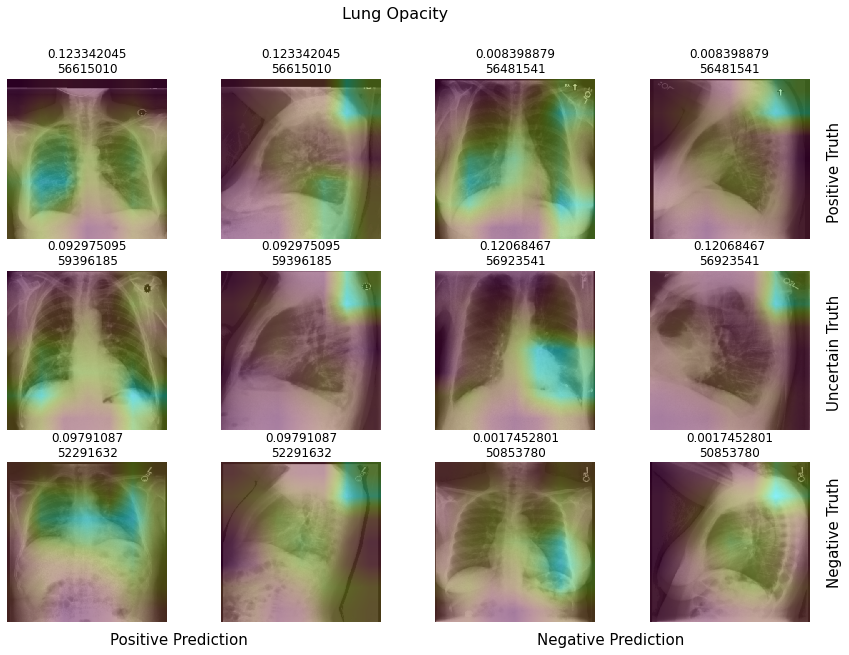

In [ ]:
for i in range(7,8):
  fig = plt.figure(figsize=(15,10))
  fig.suptitle(diseases[i], fontsize=16)
  fig.subplots_adjust(wspace=0.1)
  plt.figtext(0.3,0.1,"Positive Prediction", va="center", ha="center", size=15)
  plt.figtext(0.7,0.1,"Negative Prediction", va="center", ha="center", size=15)
  plt.figtext(0.9, 0.75, "Positive Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.5, "Uncertain Truth", rotation=90, va='center', size=15)
  plt.figtext(0.9, 0.25, "Negative Truth", rotation=90, va='center', size=15)
  p_positive = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == 1)]
  plot_grad(model, cam, i, 1,p_positive, counts[0][i])
  n_positive = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == 1)]
  plot_grad(model, cam, i, 3,n_positive, counts[1][i] - counts[0][i])
  p_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 1) & (result_merge[diseases[i]+ '_y'] == -1)]
  plot_grad(model, cam, i, 5,p_uncertain,counts[2][i])
  n_uncertain = result_merge[(result_merge[diseases[i]+'_x'] == 0) & (result_merge[diseases[i]+ '_y'] == -1)]
  plot_grad(model, cam, i, 7,n_uncertain, counts[3][i] - counts[2][i])
  p_negative = result_merge[(result_merge[diseases[i]+'_x'] == 1) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]
  plot_grad(model, cam, i, 9,p_negative, counts[4][i])
  n_negative = result_merge[(result_merge[diseases[i]+'_x'] == 0) & ((result_merge[diseases[i]+ '_y'] == 1)|  (result_merge[diseases[i]+ '_y'].isnull()))]
  plot_grad(model, cam, i, 11,n_negative, counts[5][i] - counts[4][i])
  plt.show()

### Two view ratio

In [25]:
class GradCamMultiUpperRightCount:
    def __init__(self, model, layer_names=None):
      self.model=model
      self.layer_names = layer_names

    def compute_heat_map(self, front_image, side_image, classIdx, eps=1e-8):
      outputs = [self.model.get_layer(layer_name).output for layer_name in self.layer_names]
      outputs.append(self.model.output)
      gradModel = tf.keras.models.Model(
			inputs=[self.model.inputs],
			outputs=outputs)
      
      with tf.GradientTape(persistent=True) as tape:
        (conv_outputs_front, conv_outputs_side, predictions) = gradModel([front_image, side_image])
        loss = predictions[:, classIdx]
      
      # size:(batch, height, width, convolutions)
      grads_front = tape.gradient(loss, conv_outputs_front)
      grads_side = tape.gradient(loss, conv_outputs_side)

      castConvOutputsFront = tf.cast(conv_outputs_front > 0, tf.float32)
      castGradsFront = tf.cast(grads_front > 0, tf.float32)

      castConvOutputsSide = tf.cast(conv_outputs_side > 0, tf.float32)
      castGradsSide = tf.cast(grads_side > 0, tf.float32)

      guidedGradsFront = castConvOutputsFront * castGradsFront * grads_front
      guidedGradsSide = castConvOutputsSide * castGradsSide * grads_side

      weights_front = tf.reduce_mean(guidedGradsFront, axis=(1, 2))
      weights_front = tf.expand_dims(weights_front, axis=1)
      weights_front = tf.expand_dims(weights_front, axis=1)
      cam_front = tf.reduce_sum(tf.multiply(weights_front, conv_outputs_front), axis=-1)

      weights_side = tf.reduce_mean(guidedGradsSide, axis=(1, 2))
      weights_side = tf.expand_dims(weights_side, axis=1)
      weights_side = tf.expand_dims(weights_side, axis=1)
      cam_side = tf.reduce_sum(tf.multiply(weights_side, conv_outputs_side), axis=-1)

      heatmap_front = cam_front.numpy()
      heatmap_side = cam_side.numpy()

      # scaling
      num = heatmap_front - np.min(heatmap_front, axis=(1,2))[:,np.newaxis,np.newaxis]
      deno = (np.max(heatmap_front, axis=(1,2)) - np.min(heatmap_front, axis=(1,2))) + eps
      heatmap_front = num / deno[:,np.newaxis,np.newaxis]
      heatmap_front = (heatmap_front * 255).astype("uint8")

      num = heatmap_side - np.min(heatmap_side, axis=(1,2))[:,np.newaxis,np.newaxis]
      deno = (np.max(heatmap_side, axis=(1,2)) - np.min(heatmap_side, axis=(1,2))) + eps
      heatmap_side = num / deno[:,np.newaxis,np.newaxis]
      heatmap_side = (heatmap_side * 255).astype("uint8")
    
      return heatmap_front, heatmap_side

    def count_upper_right(self, heatmap, sid, df, count_dict, idx):
      for id, map in enumerate(heatmap):
        current = df[df['study_id'] == sid[id]]
        if len(current) == 0:
          continue
        count_check = False
        if map[0,5] > 200. or map[0,6] > 200. or map[1,5] > 200. or map[1,6] > 200.:
          count_check = True
        max_other = max(np.max(map[2:]),np.max(map[0:1,0:5]))
        pred = current[diseases[idx] + "_x"].iloc[0]
        truth = current[diseases[idx] + "_y"].iloc[0]
        if count_check and max_other < 200:
          if pred:
            if truth == -1:
              count_dict[4][idx]+=1
            elif truth == 0:
              count_dict[8][idx]+=1
            else:
              count_dict[0][idx]+=1
          else:
            if truth == -1:
              count_dict[6][idx]+=1
            elif truth == 0:
              count_dict[10][idx]+=1
            else:
              count_dict[2][idx]+=1
        if pred:
            if truth == -1:
              count_dict[5][idx]+=1
            elif truth == 0:
              count_dict[9][idx]+=1
            else:
              count_dict[1][idx]+=1
        else:
            if truth == -1:
              count_dict[7][idx]+=1
            elif truth == 0:
              count_dict[11][idx]+=1
            else:
              count_dict[3][idx]+=1

In [27]:
cam = GradCamMultiUpperRightCount(model, ['relu', 'relu_side'])

In [28]:
count_dict_front = np.zeros((12, 14))
count_dict_side = np.zeros((12, 14))

In [29]:
for img, sid in tqdm.tqdm(test_dsrs_img_view):
  img_front, img_side = img
  img_front = img_front.numpy()
  img_side = img_side.numpy()
  sid = sid.numpy()
  for idx in range(14):
    heatmap_front, heatmap_side = cam.compute_heat_map(img_front, img_side, idx)
    cam.count_upper_right(heatmap_front, sid, result_merge, count_dict_front, idx)
    cam.count_upper_right(heatmap_side, sid, result_merge, count_dict_side, idx)

270it [1:26:24, 19.20s/it]


In [32]:
np.savetxt("/content/drive/My Drive/test.csv", count_dict_side, delimiter=",")